In [2]:
import numpy as np
import pandas as pd
import math
import datetime
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

采用SIR模型对武汉市新型肺炎患病人数进行预测。所使用数据来自 https://github.com/globalcitizen/2019-wuhan-coronavirus-data/tree/master/data-sources

In [3]:
Updates_NC = pd.read_csv('Updates_NC.csv')
class preProcess():
    def __init__(self):
        self.wuHan = Updates_NC[Updates_NC['城市'] == '武汉市']
        wuHanInfection = self.wuHan.groupby('报道时间')['新增确诊'].sum()
        wuHanRecovered = self.wuHan.groupby('报道时间')['新增出院'].sum()
        wuHanDead = self.wuHan.groupby('报道时间')['新增死亡'].sum()
        self.wuHan = {'报道时间':wuHanInfection.index, '新增确诊':wuHanInfection.values, '新增出院': wuHanRecovered.values, '新增死亡':wuHanDead.values}
        self.wuHan = pd.DataFrame(self.wuHan, index = [i for i in range(wuHanInfection.shape[0])])
    
    def getTotal(self):
        wuHanTotalInfection = [self.wuHan.loc[0:i,'新增确诊'].sum() for i in range(self.wuHan.shape[0])]
        wuHanTotalRecovered = [self.wuHan.loc[0:i,'新增出院'].sum() for i in range(self.wuHan.shape[0])]
        wuHanTotalDead = [self.wuHan.loc[0:i,'新增死亡'].sum() for i in range(self.wuHan.shape[0])]
        self.wuHan = self.wuHan.join(pd.DataFrame([wuHanTotalInfection,wuHanTotalRecovered ,wuHanTotalDead], index = ['累计确诊', '累计出院','累计死亡']).T)
        print(self.wuHan)
    
    def removeNoisyData(self):
        self.wuHan = self.wuHan[self.wuHan['报道时间'] >= '1月18日']
        self.wuHan.index = [i for i in range(self.wuHan.shape[0])]
        print(self.wuHan)
        
    def report(self):
        plt.plot(self.wuHan.index, self.wuHan['累计确诊'])
        plt.xlabel('Day')
        plt.ylabel('Number of people(Wu Han)')
        plt.show()

In [4]:
infectionData = preProcess()
infectionData.getTotal()

     报道时间  新增确诊  新增出院  新增死亡  累计确诊  累计出院  累计死亡
0   1月11日    41     2     1    41     2     1
1   1月12日     0     4     0    41     6     1
2   1月13日     0     1     0    41     7     1
3   1月16日     0     5     1    41    12     2
4   1月18日     4     3     0    45    15     2
5   1月19日    17     4     0    62    19     2
6   1月20日   136     6     2   198    25     4
7   1月21日    60     0     2   258    25     6
8   1月22日   167     3    11   425    28    17
9   1月24日    70     3     6   495    31    23
10  1月25日    77     1    15   572    32    38
11  1月26日    46     8     7   618    40    45
12  1月27日    80     2    18   698    42    63
13  1月28日   892     3    22  1590    45    85
14  1月29日   315     4    19  1905    49   104
15  1月30日   356     7    25  2261    56   129
16  1月31日   378    21    30  2639    77   159
17   2月1日   576    36    33  3215   113   192


如上所示是1月11日至2月2日武汉市新型肺炎患病数据，其中缺少14,15,17,23日的数据
从数据中明显可以看出18日之前的数据并不真实，因此考虑删去这部分数据

In [5]:
infectionData.removeNoisyData()

     报道时间  新增确诊  新增出院  新增死亡  累计确诊  累计出院  累计死亡
0   1月18日     4     3     0    45    15     2
1   1月19日    17     4     0    62    19     2
2   1月20日   136     6     2   198    25     4
3   1月21日    60     0     2   258    25     6
4   1月22日   167     3    11   425    28    17
5   1月24日    70     3     6   495    31    23
6   1月25日    77     1    15   572    32    38
7   1月26日    46     8     7   618    40    45
8   1月27日    80     2    18   698    42    63
9   1月28日   892     3    22  1590    45    85
10  1月29日   315     4    19  1905    49   104
11  1月30日   356     7    25  2261    56   129
12  1月31日   378    21    30  2639    77   159
13   2月1日   576    36    33  3215   113   192


In [6]:
class estimationInfectionProb():
    def __init__(self, estUsedTimeIndexBox, nContact, gamma):
        self.timeRange = np.array([i for i in range(estUsedTimeIndexBox[0],estUsedTimeIndexBox[1] + 1)])
        self.nContact, self.gamma = nContact, gamma
        self.dataStartTimeStep = 41
    
    def setInitSolution(self, x0):
        self.x0 = 0.04
        
    def costFunction(self, infectionProb):
        #print(infectionData.wuHan.loc[self.timeRange - self.dataStartTimeStep,'累计确诊'])
        #print(np.exp((infectionProb * self.nContact - self.gamma) * self.timeRange))
        res = np.array(np.exp((infectionProb * self.nContact - self.gamma) * self.timeRange) - \
                       infectionData.wuHan.loc[self.timeRange - self.dataStartTimeStep,'累计确诊'])
        return (res**2).sum() / self.timeRange.size
    
    def optimize(self):
        self.solution = minimize(self.costFunction, self.x0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
        # print('infection probaility: ', self.solution.x)
        return self.getSolution()
    
    def getSolution(self):
        return self.solution.x
    
    def getBasicReproductionNumber(self):
        self.basicReproductionNumber = self.nContact * self.solution.x[0] / (self.gamma)
        # print(self.solution)
        print("basic reproduction number:", self.basicReproductionNumber)
        return self.basicReproductionNumber

我们选取1月18日至1月22日的数据来辨识传染概率$\beta $
注：为何选取18日至22日的数据？因为武汉封城是在23日，在封城之前疾病的传播受到人为因素影响较小，所以采用封城前的数据来做参数辨识。同时由于18日之前武汉患病数据可能并不真实（有瞒报情况），所以18日之前的数据也不采用。
武汉第一例病例发现为12月8日，所以将12月8日作为开始时间，到1月18日经历了41天。

In [7]:
startTime = datetime.datetime.strptime('2019-12-08', "%Y-%m-%d")
estUsedTimeBox = [datetime.datetime.strptime('2020-01-18', "%Y-%m-%d"), datetime.datetime.strptime('2020-01-22', "%Y-%m-%d")]
estUsedTimeIndexBox = [(t - startTime).days for t in estUsedTimeBox]
print(estUsedTimeIndexBox)

[41, 45]


假设一个患病的人每天接触5个人，恢复系数$\gamma = 1/14$
在疫情早期可以认为 N = S

In [8]:
nContact, gamma = int(5), 1/14 
estInfectionProb = estimationInfectionProb(estUsedTimeIndexBox, nContact, gamma)
estInfectionProb.setInitSolution(0.04)
infectionProb = estInfectionProb.optimize()
basicReproductionNumber = estInfectionProb.getBasicReproductionNumber()

Optimization terminated successfully.
         Current function value: 10803.242316
         Iterations: 19
         Function evaluations: 38
basic reproduction number: 2.7482289886474596


In [9]:
class wuHanSIRModel():
    def __init__(self, N, beta, gamma):
        self.beta, self.gamma, self.N = beta, gamma, N
        self.t = np.linspace(0, 360, 361)
        self.setInitCondition()
    
    def odeModel(self, population, t):
        diff = np.zeros(3)
        s,i,r = population
        diff[0] = - self.beta * s * i / self.N
        diff[1] = self.beta * s * i / self.N - self.gamma * i
        diff[2] = self.gamma * i
        return diff
    
    def setInitCondition(self):
        self.populationInit = [self.N - 1, 1, 0]
        
    def solve(self):
        self.solution = odeint(self.odeModel,self.populationInit,self.t)
    
    def report(self):
        #plt.plot(self.solution[:,0],color = 'darkblue',label = 'Susceptible',marker = '.')
        plt.plot(self.solution[:,1],color = 'orange',label = 'Infection',marker = '.')
        plt.plot(self.solution[:,2],color = 'green',label = 'Recovery',marker = '.')
        plt.title('SIR Model' + ' infectionProb = '+ str(infectionProb))
        plt.legend()
        plt.xlabel('Day')
        plt.ylabel('Number of people')
        plt.show()

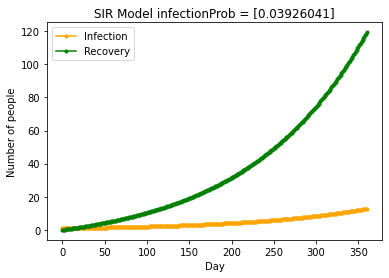

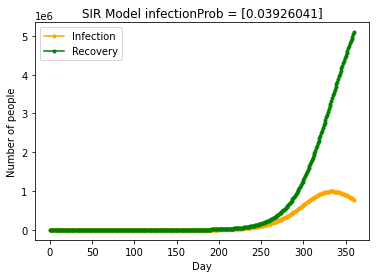

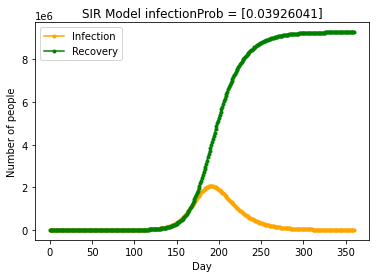

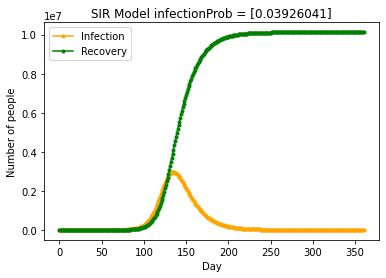

In [10]:
solutionWithParameters = []
for k in range(2,6):
    beta, gamma, N = k * infectionProb,1/14,1.1 * 10**7
    wuHanSIRModel_ = wuHanSIRModel(N, beta, gamma)
    wuHanSIRModel_.solve()
    wuHanSIRModel_.report()
    solutionWithParameters.append(wuHanSIRModel_.solution)